In [1]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "tilebox",
#     "xarray",
#     "matplotlib",
#     "ipywidgets",
#     "numpy",
#     "shapely",
#     "rasterio",
#     "scipy",
# ]
# ///

<img src="https://uploads-ssl.webflow.com/64b58e06654493327b4a59ee/6508a6973bb25aebe94d4fde_tilebox-color.svg" alt="Tilebox" width="200"/>

# Challenge 2: Earth Observation Change Detection & Risk Assessment

This notebook provides a starting point for the challenge. It covers:



**Tilebox docs available at**: [docs.tilebox.com](https://docs.tilebox.com/)

## Dependencies

Install [uv](https://docs.astral.sh/uv/) and then launch this notebook with:

```bash
uvx juv run Earth_Observation_Challenge.ipynb
```

(The `uvx` command is included when installing `uv`).

In [2]:
from tilebox.datasets import Client
from shapely.geometry import shape
import xarray as xr

# Fetching before/after imagery for the 2021 California Dixie Fire

[2021 California Dixie Fire](https://en.wikipedia.org/wiki/Dixie_Fire)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/2021_Dixie_Fire_map_1.png/960px-2021_Dixie_Fire_map_1.png" width="600" height="600">

## Querying relevant imagery

First we define our target area and our time range to query

In [3]:
# rough bounding box of the dixie fire area, generated by drawing a polygon on https://geojson.io/ 
dixie_fire_bbox = shape({"type": "Polygon", "coordinates": [
          [
            [
              -121.24392013209365,
              40.34899881341218
            ],
            [
              -121.24392013209365,
              40.04994494665513
            ],
            [
              -120.89444740138164,
              40.04994494665513
            ],
            [
              -120.89444740138164,
              40.34899881341218
            ],
            [
              -121.24392013209365,
              40.34899881341218
            ]
          ]
        ]
})

# The fire lasted from 2021-07-13 to 2021-10-25
time_range_before_fire = ("2021-06-01", "2021-07-01")

# However for the after image here we look at it a year later
# in summer again, so that the visual comparison due to the sun
# angle is easier here
time_range_after_fire = ("2022-06-01", "2022-07-01")

In [4]:
def query(dataset, collections, temporal_extent, spatial_extent):
    """
    Query a spatio-temporal Tilebox dataset for a given temporal and spatial extent

    Args:
        dataset: The Tilebox Dataset to query
        collections: List of collection names to query in
        temporal_extent: (start, end) time to query
        spatial_extent: Polygon specifying the area to query

    Returns:
        xr.Dataset with the found results
    """
    all_results = []
    for collection in collections:
        results = dataset.collection(collection).query(
            temporal_extent=temporal_extent,
            # more information: https://docs.tilebox.com/datasets/query/filter-by-location#intersects
            spatial_extent={"geometry": spatial_extent, "mode": "intersects"}
        )
        if results:
            all_results.append(results)

    if not all_results:  # no matches found, return an empty dataset
        return xr.Dataset()

    return xr.concat(all_results, dim="time")

In [5]:
# query L2 data products from all three sentinel 2 satellites
sentinel2_l2_collections = ["S2A_S2MSI2A", "S2B_S2MSI2A", "S2C_S2MSI2A"]

# Create your key here: https://console.tilebox.com/account/api-keys
client = Client()
sentinel2 = client.dataset("open_data.copernicus.sentinel2_msi")

before = query(sentinel2, sentinel2_l2_collections, time_range_before_fire, dixie_fire_bbox)
after = query(sentinel2, sentinel2_l2_collections, time_range_after_fire, dixie_fire_bbox)

if before:
    print(f"  ✓ Found {before.sizes['time']} matching granules before the fire.")
else:
    print(f"  ✗ No matching granules found before the fire.")

if after:
    print(f"  ✓ Found {after.sizes['time']} matching granules after the fire.")
else:
    print(f"  ✗ No matching granules found after the fire.")

  ✓ Found 6 matching granules before the fire.
  ✓ Found 12 matching granules after the fire.


## Filter for cloud coverage

In [6]:
max_cloud_cover = 1  # maximum 1 % cloud cover

before = before.isel(time=before.cloud_cover <= max_cloud_cover)
after = after.isel(time=after.cloud_cover <= max_cloud_cover)

print(f"Matching granules with cloud coverage <1%")
print(f"  - {before.sizes['time']} granules before the fire")
print(f"  - {after.sizes['time']} granules after the fire.")

Matching granules with cloud coverage <10%
  - 3 granules before the fire
  - 2 granules after the fire.


## Accessing Product Data

Tilebox doesn't host the actual image data, just the metadata catalog for efficient indexing and querying. To access an download Copernicus data, you can use the [Tilebox Copernicus storage client](https://docs.tilebox.com/storage/clients#copernicus-data-space).

#### Copernicus S3 Credentials

To access the data, you'll need to create a free account at https://dataspace.copernicus.eu/

And then, once logged in generate `S3` Credentials on this page:

https://eodata-s3keysmanager.dataspace.copernicus.eu/panel/s3-credentials

In [7]:
from tilebox.storage import CopernicusStorageClient

In [8]:
copernicus_storage_client = CopernicusStorageClient(
    access_key="<YOUR_S3_ACCESS_KEY>",  # see credentials description above
    secret_access_key="<YOUR_S3_SECRET_ACCESS_KEY>"
)

### Preview Quicklook

Before we download the full product (which is quite large), let's quickly preview an image to make sure we got the area right

In [11]:
before_product = before.isel(time=0)  # select any one of the granules
after_product = after.isel(time=-1)  # using regular python list index logic (-1 means last one)

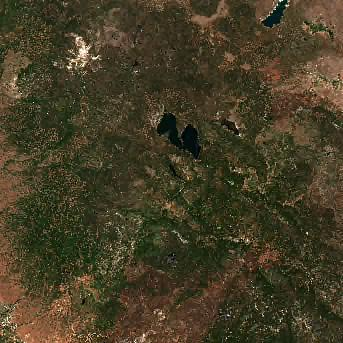

In [12]:
copernicus_storage_client.quicklook(before_product)

### Downloading and querying product files

That looks good, let's download the actual payload data

Sentinel-2 data is available in **multiple resolutions**, and every band is located in its own file.
For a quick visual analysis, we typically want to load three bands in the Red, Green and Blue spectral range, so that we can compute an RGB composite.

The necessary information about the Sentinel-2 MSI Instrument can be found here:
https://sentiwiki.copernicus.eu/web/s2-mission#S2Mission-SpatialResolutionS2-Mission-Spatial-Resolutiontrue

![](https://sentiwiki.copernicus.eu/__attachments/1687033/image-20230605-122808.png?inst-v=620842ee-e3f1-4a41-be8e-09f8a7d4808d)

### Downloading the Before-fire product

We'll choose the 20m resolution version of the data, for a quick visualization

In [13]:
product_files = copernicus_storage_client.list_objects(before_product)
resolution_20m_files_before = [file for file in product_files if "R20m" in file]
red_band_20m_before = [file for file in resolution_20m_files_before if "B04" in file][0]
green_band_20m_before = [file for file in resolution_20m_files_before if "B03" in file][0]
blue_band_20m_before = [file for file in resolution_20m_files_before if "B02" in file][0]

In [ ]:
before_product_path = copernicus_storage_client.download_objects(before_product, [red_band_20m_before, green_band_20m_before, blue_band_20m_before])

### Downloading the After-fire product

Let's do the same for the `after` product

In [17]:
product_files = copernicus_storage_client.list_objects(after_product)
resolution_20m_files_after = [file for file in product_files if "R20m" in file]
red_band_20m_after = [file for file in resolution_20m_files_after if "B04" in file][0]
green_band_20m_after = [file for file in resolution_20m_files_after if "B03" in file][0]
blue_band_20m_after = [file for file in resolution_20m_files_after if "B02" in file][0]

In [ ]:
after_product_path = copernicus_storage_client.download_objects(after_product, [red_band_20m_after, green_band_20m_after, blue_band_20m_after])

### Reading products as numpy arrays

We'll use [rasterio](https://rasterio.readthedocs.io/en/stable/) to read the Sentinel-2 product files into memory

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def read_band(product_path, band_name) -> np.ndarray:
    with rasterio.open(product_path / band_name) as arr:
        return arr.read(1) / 10000  # s2 reflectance values are stored as uint16, scaled by factor 10000

In [24]:
before_rgb_composite = np.stack([
    read_band(before_product_path, red_band_20m_before),
    read_band(before_product_path, green_band_20m_before),
    read_band(before_product_path, blue_band_20m_before),
], axis=-1)

In [30]:
after_rgb_composite = np.stack([
    read_band(after_product_path, red_band_20m_after),
    read_band(after_product_path, green_band_20m_after),
    read_band(after_product_path, blue_band_20m_after),
], axis=-1)

In [38]:
# compute difference between the two images
change = np.linalg.norm(before_rgb_composite - after_rgb_composite, axis=2)

## Visualize the change

In [51]:
brighten_factor = 2.6  # the reflectance values are quite dark, let's brighten it a bit for visualization

Text(0.5, 1.0, '1-year change\nAreas with most significat change')

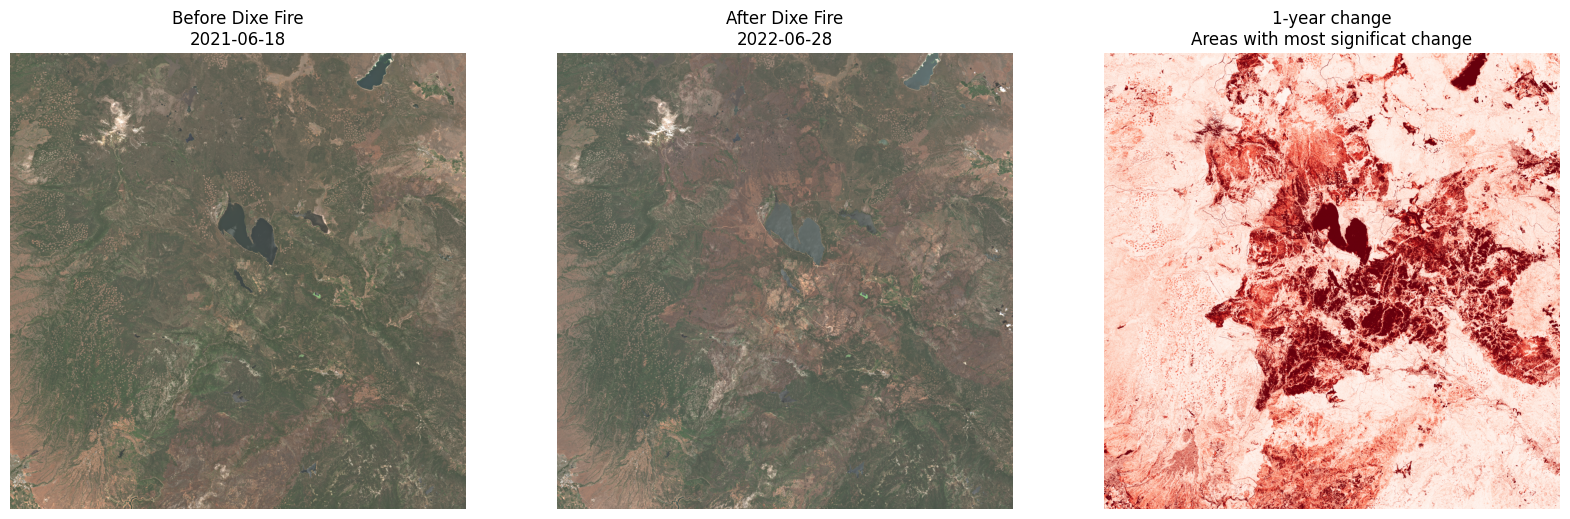

In [77]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(20, 10)

axes[0].imshow(np.clip(before_rgb_composite * brighten_factor, 0, 1))
axes[0].axis("off")
axes[0].set_title(f"Before Dixe Fire\n{before_product.time.dt.strftime('%Y-%m-%d').item()}")

axes[1].imshow(np.clip(after_rgb_composite * brighten_factor, 0, 1))
axes[1].axis("off")
axes[1].set_title(f"After Dixe Fire\n{after_product.time.dt.strftime('%Y-%m-%d').item()}")

axes[2].imshow(change, cmap="Reds", vmin=np.percentile(change, 10), vmax=np.percentile(change, 90))
axes[2].axis("off")
axes[2].set_title("1-year change\nAreas with most significant change");

## Todo

- mention other satellites, instruments
- mention / link regridding methods
- maybe provide some resources about change detection / ndvi / foundation models